# Prepare data for NYC network

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.sparse import csr_matrix
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams.update({
    'figure.dpi': 80,
    'figure.titlesize': 25,
    'axes.titlesize': 15,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'legend.title_fontsize': 15
})

Objective:
+ Get the distribution for passenger generation rate
+ Get the activate drivers versus hourly wages

For extension

In [2]:
tt = pd.read_csv('data/travel_times_2013.csv')
links = pd.read_csv('data/links.csv')
nodes = pd.read_csv('data/nodes.csv')

# Load three months data

In [115]:
trip_data = pd.read_csv('data/compressed/FOIL2013/trip_data_3.zip')[['medallion', ' hack_license', ' pickup_datetime', ' dropoff_datetime', ' passenger_count',\
                                                                    ' trip_time_in_secs', ' trip_distance', ' pickup_longitude', ' pickup_latitude',\
                                                                    ' dropoff_longitude', ' dropoff_latitude']]
trip_data = pd.concat([trip_data, pd.read_csv('data/compressed/FOIL2013/trip_fare_3.zip')[[' fare_amount', ' surcharge', ' mta_tax', ' tip_amount', ' tolls_amount',\
                                                                     ' total_amount']]], axis = 1)

for month in range(4,6):
    tmp_trip_data = pd.read_csv('data/compressed/FOIL2013/trip_data_'+str(month)+'.zip')[['medallion', ' hack_license', ' pickup_datetime', ' dropoff_datetime', ' passenger_count',\
                                                                    ' trip_time_in_secs', ' trip_distance', ' pickup_longitude', ' pickup_latitude',\
                                                                    ' dropoff_longitude', ' dropoff_latitude']]
    tmp_trip_data = pd.concat([tmp_trip_data, pd.read_csv('data/compressed/FOIL2013/trip_fare_'+str(month)+'.zip')[[' fare_amount', ' surcharge', ' mta_tax', ' tip_amount', ' tolls_amount',\
                                                                         ' total_amount']]], axis = 1)
    trip_data = trip_data.append(tmp_trip_data)


In [119]:
trip_data['timestamp'] = pd.to_datetime(trip_data[' pickup_datetime'], errors = 'coerce')

# preprocessing, remove invalid data
trip_data = trip_data[(trip_data[' trip_distance'] >= 0.1) & (trip_data[' trip_time_in_secs'] >= 60)]

trip_data['day_of_year'], trip_data['hour'], trip_data['minute'] = trip_data['timestamp'].dt.day_of_year, trip_data['timestamp'].dt.hour, trip_data['timestamp'].dt.minute

In [116]:
total_vehicle = len(trip_data['medallion'].unique())
total_vehicle

13659

# Active driver vs. income

In [120]:
trip_data.sort_values(['medallion', 'timestamp'], inplace=True)
trip_data['diffs'] = trip_data['timestamp'].diff()

mask = trip_data['medallion'] != trip_data['medallion'].shift(1)
trip_data.loc[mask, 'diffs'] = np.nan

# filter data
trip_data['pre_diffs'] = trip_data['diffs'].dt.seconds.shift(-1)

trip_data['pre_diffs'] = trip_data['pre_diffs'] - trip_data[' trip_time_in_secs']
trip_data['post_diffs'] = trip_data['pre_diffs'].shift(1)

mask2 = mask | (trip_data['pre_diffs']>1800) | (trip_data['post_diffs']>1800)
trip_data = trip_data.loc[mask2]

# trip_data.to_csv("data/driver_start_end_trip_data.csv", index = None)

In [138]:
trip_data.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,...,tip_amount,tolls_amount,total_amount,timestamp,day_of_year,hour,minute,diffs,pre_diffs,post_diffs
3514,2013000001,2013000001,2013-03-01 00:08:00,2013-03-01 00:25:00,2,1020,3.30,-73.993904,40.751301,-73.988815,...,1.0,0.0,16.5,2013-03-01 00:08:00,60,0,8,NaT,180.0,NaN
26336,2013000001,2013000001,2013-03-01 01:17:00,2013-03-01 01:34:00,2,1020,4.50,-73.900131,40.740696,-73.955223,...,0.0,0.0,18.5,2013-03-01 01:17:00,60,1,17,0 days 00:32:00,21240.0,1260.0
84101,2013000001,2013017344,2013-03-01 07:28:00,2013-03-01 07:35:00,1,420,2.46,-73.949806,40.776363,-73.937180,...,0.0,0.0,9.5,2013-03-01 07:28:00,60,7,28,0 days 06:11:00,540.0,21240.0
267067,2013000001,2013017344,2013-03-01 14:29:00,2013-03-01 15:28:00,1,3540,21.46,-73.985245,40.760448,-73.794075,...,0.0,4.8,57.3,2013-03-01 14:29:00,60,14,29,0 days 00:30:00,5160.0,1320.0
324579,2013000001,2013000001,2013-03-01 16:54:00,2013-03-01 17:01:00,1,420,1.33,-73.992332,40.724236,-74.000938,...,0.0,0.0,8.5,2013-03-01 16:54:00,60,16,54,0 days 02:25:00,180.0,5160.0


In [141]:
np.max(act_drivers)

10908.0

In [140]:
# trip_data = pd.read_csv("data/driver_start_end_trip_data.csv")

act_drivers = np.zeros(365*24*60)
current_license = -1

for _, row in trip_data.iterrows():
    if(current_license != row['medallion']):
        started = True
        current_license = row['medallion']
        start_time = (row['day_of_year']-1)*24*60+ row['hour']*60+row['minute']
    if(row['pre_diffs']>1800 and started): # last record
        started = False
        end_time = (row['day_of_year']-1)*24*60+ row['hour']*60+row['minute'] + row[' trip_time_in_secs']//60
        act_drivers[int(start_time):int(end_time)]+=1
        continue
    elif(row['post_diffs']>1800 and not started): # first record
        started = True
        start_time = max((row['day_of_year']-1)*24*60+ row['hour']*60+row['minute'],end_time)

In [14]:
# np.save("data/active_drivers_per_min.npy", act_drivers)
act_drivers = np.load("data/active_drivers_per_min.npy")

In [ ]:
trip = pd.read_csv('data/trip_data_matched.csv')

In [97]:
# income per minute
trip_data = trip.groupby(['day_of_year','hour','minute']).agg({' fare_amount': sum, ' surcharge':sum, ' mta_tax':sum,' tip_amount': sum, ' tolls_amount': sum, ' total_amount': sum})
trip_data = trip_data.reset_index()

In [98]:
income_per_min = np.zeros(365*24*60)
column = ' fare_amount'
for _, row in trip_data.iterrows():
    index = int((row['day_of_year']-1)*24*60+ row['hour']*60+row['minute'])
    income_per_min[index] = row[column]

In [15]:
# np.save("data/income_per_min.npy", income_per_min)
income_per_min = np.load("data/income_per_min.npy")

In [16]:
# trip_data = pd.read_csv('data/trip_data_matched.csv')

In [17]:
plt.plot(income_per_30min)

NameError: name 'income_per_30min' is not defined

In [18]:
# reagg the data to reduce the variance, for every 30 minutes
act_drivers_per_30min = np.zeros(365*24*2)
income_per_30min = np.zeros(365*24*2)

for i in range(365*24*2):
    act_drivers_per_30min[i] = np.max(act_drivers[(i*30):((i+1)*30)])
    income_per_30min[i] = np.sum(income_per_min[(i*30):((i+1)*30)])

In [19]:
keep_ind = (income_per_30min>0)

In [26]:
# inds = np.random.choice(np.arange(sum(keep_ind)), 5000)
# plt.plot((income_per_30min/(act_drivers_per_30min+1e-4))[keep_ind][inds], act_drivers_per_30min[keep_ind][inds]/13659,'*')
# plt.xlim([0,20])

In [21]:
import scipy.optimize
import scipy.stats

In [22]:
# f = lambda x,mu,sigma: scipy.stats.norm(mu,sigma).cdf(x)
# mu,sigma = scipy.optimize.curve_fit(f,(income_per_min/(act_drivers+1e-1)),act_drivers/12153)[0]

In [23]:
f = lambda x,mu,sigma: scipy.stats.norm(mu,sigma).cdf(x)
mu,sigma = scipy.optimize.curve_fit(f,(income_per_30min/(act_drivers_per_30min+1e-4))[keep_ind],(act_drivers_per_30min/13659)[keep_ind])[0]

f2 = lambda x,mu,sigma: scipy.stats.norm(mu,sigma).cdf(x)
mu2,sigma2 = scipy.optimize.curve_fit(f2,np.log((income_per_30min/(act_drivers_per_30min+1e-4))[keep_ind]+1),(act_drivers_per_30min/13659)[keep_ind])[0]

In [24]:
# calculate the R-square, and statistic significance if available

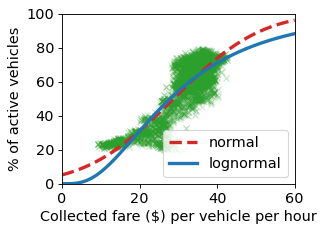

In [25]:
fig, ax = plt.subplots(figsize=(4,3))

dx = 0.01
X = np.arange(0, 30, dx)
CY = f(X, mu, sigma)
CY2 =f2(np.log(X+1), mu2, sigma2)

# plot the fitted curve
inds = np.random.choice(np.arange(sum(keep_ind)), 10000)
plt.plot(2*(income_per_30min/(act_drivers_per_30min+1e-1))[keep_ind][inds], 100*act_drivers_per_30min[keep_ind][inds]/13659,'x',alpha=0.1, color='C2')
plt.plot(2*X, 100*CY, '--', color = 'C3', label='normal', lw=3)
plt.plot(2*X, 100*CY2, color = 'C0', label= 'lognormal', lw=3)

plt.xlim([0,60])
plt.ylim([0,100])
plt.legend()

plt.ylabel("% of active vehicles")
plt.xlabel("Collected fare ($) per vehicle per hour")

plt.tight_layout()

plt.savefig("figs/fare_vs_drivers.png", dpi=300)
plt.savefig("figs/fare_vs_drivers.pdf")

# Demand per minute

In [7]:
background = gpd.read_file("data/map/taxi_zones_wgs84.shp")[['LocationID','geometry']]

In [24]:
trip_data = trip_data[(trip_data['day_of_year']>62)&(trip_data['day_of_year']<=132)]
len(trip_data)/70

499391.0

In [25]:
# # extract one month data
trip_data['geometry'] = gpd.points_from_xy(trip_data[' pickup_longitude'], trip_data[' pickup_latitude'])
trip_data = gpd.GeoDataFrame(trip_data, geometry=trip_data['geometry'])

NameError: name 'background' is not defined

In [27]:
trip_data = gpd.sjoin(trip_data, background, how='left', op='within')
trip_data.rename({'LocationID':'pickup_loc'}, inplace=True, axis = 1)

trip_data.drop(['index_right'], axis = 1, inplace= True)

trip_data['geometry'] = gpd.points_from_xy(trip_data[' dropoff_longitude'], trip_data[' dropoff_latitude'])
trip_data = gpd.sjoin(trip_data, background, how='left', op='within')

trip_data.rename({'LocationID':'dropoff_loc'}, inplace=True, axis = 1)

trip_data.drop(['index_right','geometry'], axis = 1, inplace= True)
# trip_data.to_csv('data/trip_data_matched.csv', index = None)

C:\Users\User\AppData\Local\Temp/ipykernel_66676/15359684.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  trip_data = gpd.sjoin(trip_data, background, how='left', op='within')
C:\Users\User\AppData\Local\Temp/ipykernel_66676/15359684.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  trip_data = gpd.sjoin(trip_data, background, how='left', op='within')


KeyError: "['diffs'] not found in axis"

In [33]:
len(trip_data)/70

499391.0

In [ ]:
trip_data = pd.read_csv('data/trip_data_matched.csv')
trip_data['speed'] = 1609*trip_data[' trip_distance'] /trip_data[' trip_time_in_secs'] 
trip_data = trip_data.groupby(['day_of_year','hour','minute','pickup_loc','dropoff_loc']).agg({'speed': ['mean', 'count'], ' trip_time_in_secs': np.mean, ' trip_distance': np.mean })
trip_data = trip_data.reset_index()
trip_data.columns = [' '.join(col).strip() for col in trip_data.columns.values]

In [ ]:
# od demand per minute
data = []
rows = []
cols = []
for _,row in trip_data.iterrows():
    if(row['pickup_loc']<=263 and row['dropoff_loc']<=263):
        data.append(row['speed count'])
        rows.append(int((row['day_of_year']-63)*24*60+row['hour']*60+row['minute']))
        cols.append(int((row['pickup_loc']-1)*263 + row['dropoff_loc']-1))

In [ ]:
od_sparse = csr_matrix((data, (rows, cols)), shape=(70*24*60, 263*263))

In [ ]:
np.sum(od_sparse)/70

In [37]:
np.sum(od_sparse)/70

489422.65714285715

In [9]:
# scipy.sparse.save_npz('data/od_sparse.npz',od_sparse)
od_sparse = scipy.sparse.load_npz('data/od_sparse.npz')

In [ ]:
trip_data = pd.read_csv('data/trip_data_matched.csv')
trip_data['speed'] = 1609*trip_data[' trip_distance'] /trip_data[' trip_time_in_secs'] 
trip_data = trip_data.groupby(['day_of_year','hour','minute','pickup_loc','dropoff_loc']).agg({'speed': ['mean', 'count'], ' trip_time_in_secs': np.mean, ' trip_distance': np.mean, ' fare_amount': np.mean })
trip_data = trip_data.reset_index()
trip_data.columns = [' '.join(col).strip() for col in trip_data.columns.values]

In [ ]:
data = []
rows = []
cols = []
for _,row in trip_data.iterrows():
    if(row['pickup_loc']<=263 and row['dropoff_loc']<=263):
        data.append(row['fare_amount mean'])
        rows.append(int((row['day_of_year']-63)*24*60+row['hour']*60+row['minute']))
        cols.append(int((row['pickup_loc']-1)*263 + row['dropoff_loc']-1))

In [ ]:
fare_sparse = csr_matrix((data, (rows, cols)), shape=(70*24*60, 263*263))

In [10]:
# scipy.sparse.save_npz('data/fare_sparse.npz',fare_sparse)
fare_sparse = scipy.sparse.load_npz('data/fare_sparse.npz')

In [11]:
# temporal patterns
i = 19*60 # 0 to 60*24
k = 62303

Y, X =np.histogram(od_sparse[[i+j*7*24*60 for j in range(10)], k].toarray(), bins = range(np.max(2+od_sparse[[i+j*7*24*60 for j in range(10)], k].toarray()).astype(int)))
X = X[:-1]
Y = Y/(sum(Y)+1e-4)

In [12]:
f = lambda x,mu: scipy.stats.poisson(mu).pmf(x)
mu = scipy.optimize.curve_fit(f,X,Y)[0]

f2 = lambda x,mu,sigma: scipy.stats.norm(mu,sigma).pdf(x)
mu2,sigma2 = scipy.optimize.curve_fit(f2,np.log(X+1),Y)[0]

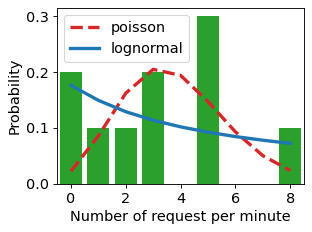

In [13]:
fig, ax = plt.subplots(figsize=(4,3))

dx = 1
CY = f(X, mu)
CY2 =f2(np.log(X+1), mu2, sigma2)

# fit this with Poisson and lognormal
plt.bar(X, Y, color= 'C2')
plt.plot(X, CY, '--', color = 'C3', label='poisson', lw=3)
plt.plot(X, CY2, color = 'C0', label= 'lognormal', lw=3)

plt.xlim([0-.5,max(X)+.5])
plt.legend()

plt.ylabel("Probability")
plt.xlabel("Number of request per minute")

plt.tight_layout()

plt.savefig("figs/demand_distribution.png", dpi=300)
plt.savefig("figs/demand_distribution.pdf")

# Prepare the inputs for numerical experiments

In [87]:
trip_data = pd.read_csv('data/trip_data_matched.csv')

In [88]:
trip_data = trip_data.groupby(['pickup_loc', 'dropoff_loc']).agg({' trip_distance':np.mean ,' trip_time_in_secs': np.mean}).reset_index()

In [89]:
# travel distance td,
td = np.zeros((263, 263))
tt = np.zeros((263, 263))
for _, row in trip_data.iterrows():
    if(row['pickup_loc']<=263 and row['dropoff_loc']<=263):
        td[int(row['pickup_loc']-1),int(row['dropoff_loc']-1)] = row[' trip_distance']
        tt[int(row['pickup_loc']-1),int(row['dropoff_loc']-1)] = row[' trip_time_in_secs']//60
    
# try to fill the unfilled value with something
for i in range(263):
    for j in range (263):
        if(td[i,j]==0):
            min_dist = 10000
            for k in range(263):
                if(td[i,k]>0 and td[k,j]>0):
                    min_dist = min(min_dist, td[i,k]+td[k,j])
            td[i,j] = min_dist

for i in range(263):
    for j in range (263):
        if(tt[i,j]==0):
            min_time = 10000
            for k in range(263):
                if(tt[i,k]>0 and tt[k,j]>0):
                    min_time = min(min_time, tt[i,k]+tt[k,j])
            tt[i,j] = min_time

In [27]:
import scipy

od_sparse = scipy.sparse.load_npz('data/od_sparse.npz')

In [4]:
np.sum(od_sparse)/70

489422.65714285715

In [5]:
import scipy.stats

In [8]:
# vehicle target pricing
# dd_train, use distribution, which is the mean of the first three weeks
# dp_train, second param (if needed) for demand distribution, unused for now
i=0
dd_train = od_sparse[i*7*24*60:((i+1)*7*24*60)]
for i in range(1,9):
    dd_train += (od_sparse[i*7*24*60:((i+1)*7*24*60)])
dd_train/=9

# dd_test, directly use the demand 
i=9
dd_test = od_sparse[i*7*24*60:((i+1)*7*24*60)]


In [15]:
np.random.seed(42)
vp = scipy.stats.norm.rvs(mu,sigma, size = 13659)

In [156]:
import numpy as np

In [157]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

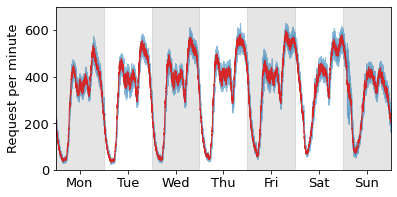

In [53]:
# od_sparse = scipy.sparse.load_npz('data/od_sparse.npz')
# vehicle target pricing
# dd_train, use distribution, which is the mean of the first three weeks
# dp_train, second param (if needed) for demand distribution, unused for now
i=0
dd_train = np.sum(od_sparse[i*7*24*60:((i+1)*7*24*60)],1).A
dd_var = np.sum(od_sparse[i*7*24*60:((i+1)*7*24*60)],1).A**2
for i in range(1,9):
    dd_train += np.sum(od_sparse[i*7*24*60:((i+1)*7*24*60)],1).A
    dd_var += np.sum(od_sparse[i*7*24*60:((i+1)*7*24*60)],1).A**2
dd_train/=9
dd_var/=9
dd_std = np.sqrt(dd_var-dd_train**2)

fig,ax = plt.subplots(figsize= (6,3))

plt.plot(dd_train, linewidth=1, color = 'C3')
plt.fill_between(range(10080),(dd_train-dd_std)[:,0], (dd_train+dd_std)[:,0],color= 'C0', alpha=0.5)

plt.xlim([0,10080])
plt.ylim([0,700])

ax.set_xticks([i*1440+720 for i in range(7)])
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

for i in range(0,7,2):
    rect = matplotlib.patches.Rectangle((0+1440*i, 0),
                                     1440, 800,
                                     color ='C7',alpha = 0.2,zorder=0)
    ax.add_patch(rect)

ax.set_ylabel('Request per minute')

plt.savefig("figs/demand_distribution.png", dpi=300)
plt.savefig("figs/demand_distribution.pdf")

In [ ]:
theta = np.arctan((y[np.argsort(y)[-3]]-y[np.argsort(x)[1]])/(x[np.argsort(y)[-3]]-x[np.argsort(x)[1]]))

In [41]:
x = (background.iloc[keep_ind].reset_index().geometry.centroid.x).values
y = (background.iloc[keep_ind].reset_index().geometry.centroid.y).values

C:\Users\User\AppData\Local\Temp/ipykernel_14672/1801932401.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x = (background.iloc[keep_ind].reset_index().geometry.centroid.x).values
C:\Users\User\AppData\Local\Temp/ipykernel_14672/1801932401.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y = (background.iloc[keep_ind].reset_index().geometry.centroid.y).values


C:\Users\User\AppData\Local\Temp/ipykernel_14672/2893130714.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x = (background.iloc[keep_ind].reset_index().geometry.centroid.x).values
C:\Users\User\AppData\Local\Temp/ipykernel_14672/2893130714.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y = (background.iloc[keep_ind].reset_index().geometry.centroid.y).values


[]

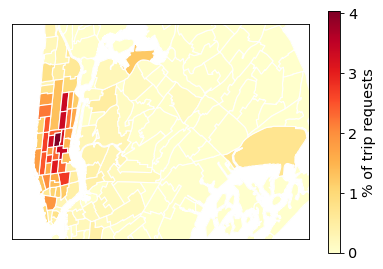

In [40]:
od_agg = np.sum(od_sparse, axis = 0).reshape((263,263)).A
od_start = np.sum(od_agg, axis = 0)
od_end = np.sum(od_agg, axis = 1)
od_start /= np.sum(od_start)
od_end /= np.sum(od_end)

keep_ind = [True]*263 #(od_start>0.01) | (od_end >0.01)

fig,ax = plt.subplots()

background.rotate(theta/2/np.pi*180, origin=background.unary_union.centroid).plot(ax=ax, facecolor = 'lightgrey')
selected = background.iloc[keep_ind].copy().reset_index()
selected['pickup'] = od_start[keep_ind] * 100
selected.geometry = selected.rotate(theta/2/np.pi*180, origin=background.unary_union.centroid)
selected.plot(ax = ax, column='pickup', edgecolor='white', cmap = 'YlOrRd', lw=1, legend=True,\
             legend_kwds={'label': "% of trip requests"})

x = (background.iloc[keep_ind].reset_index().geometry.centroid.x).values
y = (background.iloc[keep_ind].reset_index().geometry.centroid.y).values

plt.xlim([-74.05, -73.74])
plt.ylim([40.65, 40.82])

ax.set_xticks([])
ax.set_yticks([])
# ax.scatter(x[np.argsort(y)[-3]],y[np.argsort(y)[-3]], color= 'red')
# ax.scatter(x[np.argsort(x)[1]],y[np.argsort(x)[1]], color= 'red')

# plt.savefig("figs/NYC_background.png", dpi=300)
# plt.savefig("figs/NYC_background.pdf")

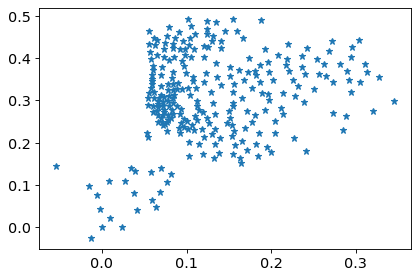

In [44]:
plt.plot(x2,y2, '*')

In [64]:
divider = 5e-3 # ~1km
divider2 = 1e-2 # ~1km 

x2 = ((x-x[np.argsort(x)[1]]) * np.cos(np.pi/2-theta) - (y-y[np.argsort(x)[1]])*np.sin(np.pi/2-theta))
y2 = ((x-x[np.argsort(x)[1]])  * np.sin(np.pi/2-theta) + (y-y[np.argsort(x)[1]])*np.cos(np.pi/2-theta))

# while flag:
xind = x2//divider
yind = y2//divider2

# if np duplicate pairs
res = [(i,j) for i,j in zip(xind, yind)]
# if(len(res) == len(set(res))):
#     flag = False
# else:
#     divider /= 2

In [46]:
res = [(int(i[0] - min(xind)), int(i[1]-min(yind))) for i in res] 

In [69]:
selected['od_pair'] = yind#list(range(40)) # res res_new

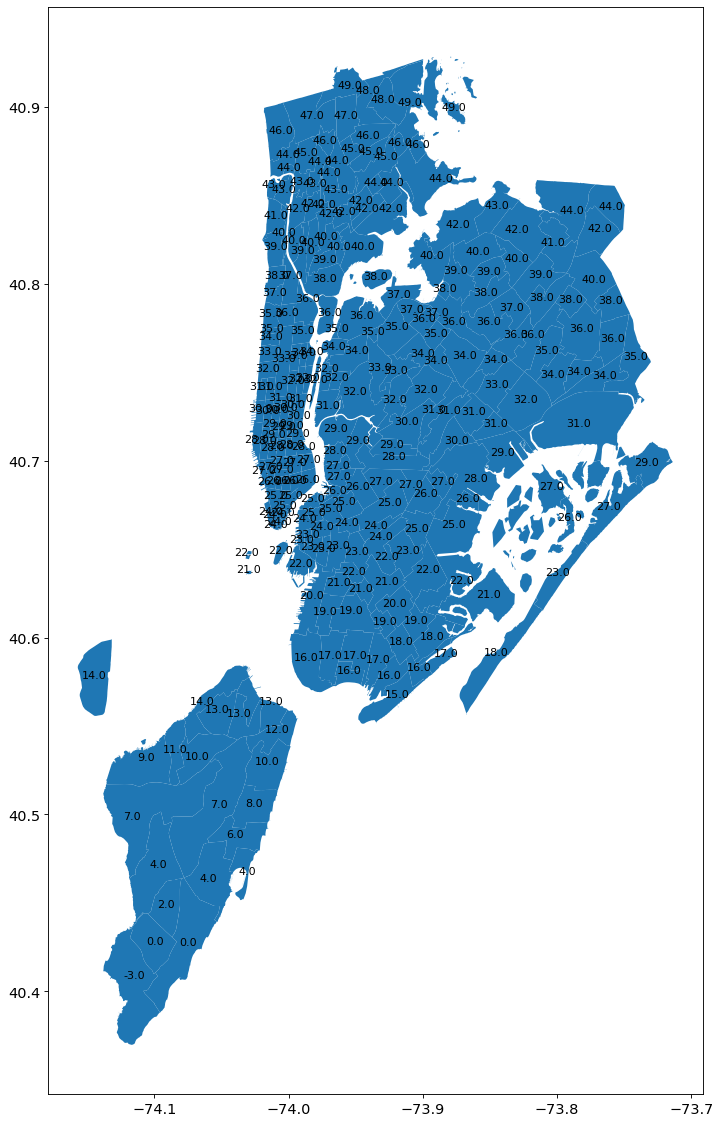

In [70]:
fig,ax = plt.subplots(figsize=(18,18))

selected.plot(ax = ax)
selected['coords'] = selected['geometry'].apply(lambda x: x.representative_point().coords[:])
selected['coords'] = [coords[0] for coords in selected['coords']]
for idx, row in selected.iterrows():
    ax.annotate(text=row['od_pair'], xy=row['coords'],
                 horizontalalignment='center')

# Think how to efficiently implement this permutation operation.

In [58]:
# reindex_res
unique_row_ind = [i[0] for i in res] 
unique_col_ind = [i[1] for i in res]  

unique_row_ind.sort()
unique_col_ind.sort()

unique_row_ind = np.unique(unique_row_ind)
unique_col_ind = np.unique(unique_col_ind)

In [59]:
unique_row_dict = {}
unique_col_dict = {}

for i in range(len(unique_row_ind)):
    unique_row_dict[unique_row_ind[i]] = i
for i in range(len(unique_col_ind)):
    unique_col_dict[unique_col_ind[i]] = i

In [60]:
res_new=[]
for row in res:
    res_new.append((unique_row_dict[row[0]], unique_col_dict[row[1]]))

In [63]:
m = len(unique_row_dict)
n = len(unique_col_dict)

print(m)
print(n)

new_res = [[] for i in range(int(m**2))]

for i in range(int(m**2)):
    for j in range(int(n**2)):
        new_res[i].append([])


i = 0
for i1 in range(int(m)):
    for j1 in range(int(n)):
        for i2 in range(int(m)):
            for j2 in range(int(n)):
                for j in range(len(res_new)):
                    for k in range(len(res_new)):
                        if (i1,j1)==res_new[j] and (i2, j2)==res_new[k]:
                            i+=1
                            new_res[i1 * m + i2 % m][j1 *n + j2 %n].append((j,k))
                    
new_res2 = [[] for i in range(int(m**2))]

for i in range(int(m**2)):
    for j in range(int(n**2)):
        new_res2[i].append([])

i = 0
for i1 in range(int(m)):
    for j1 in range(int(n)):
        for i2 in range(int(m)):
            for j2 in range(int(n)):
                for j in range(len(res_new)):
                    for k in range(len(res_new)):
                        if (i1,j1)==res_new[j] and (i2, j2)==res_new[k]:
                            i+=1
                            new_res2[i1 % m + i2 * m][j1 % n + j2 * n].append((j,k))

65
48


KeyboardInterrupt: 

In [ ]:
row_index = np.zeros(node_size**2,dtype=int)
col_index = np.zeros(node_size**2,dtype=int)
for i in range(int(m**2)):
    for j in range(int(n**2)):
        for (source, target) in new_res[i][j]:
            row_index[source * node_size + target] = i
            col_index[source * node_size + target] = j

row_index2 = np.zeros(node_size**2,dtype=int)
col_index2 = np.zeros(node_size**2,dtype=int)
for i in range(int(m**2)):
    for j in range(int(n**2)):
        for (source, target) in new_res2[i][j]:
            row_index2[source * node_size + target] = i
            col_index2[source * node_size + target] = j

np.save('nyc_large/permutation.npy', [row_index, col_index])
np.save('nyc_large/permutation2.npy', [row_index2, col_index2])

In [ ]:
# row_index 
# col_index

In [ ]:
# I = 40

# res_x = np.zeros((40,40))
# res_y = np.zeros((40,40))

# for i in range(I):
#     for j in range(I):
#         i2 = xind_sorted[i]
#         j2 = yind_sorted[j]
#         res_x[i,j] = i2
#         res_y[i,j] = j2

# res = [[] for i in range(40)]

# for i in range(40):
#     for j in range(40):
#         res[i].append((res_x[i,j], res_y[i,j]))
        
# res = np.array(res, dtype= int)

In [ ]:
# consider normal + poisson for the sake of simplicity
np.save('nyc_large/td.npy', td.reshape((263,263))[keep_ind,:][:,keep_ind])
np.save('nyc_large/tt.npy', tt.reshape((263,263))[keep_ind,:][:,keep_ind])
np.save('nyc_large/vp.npy', vp/30)
np.save('nyc_large/dd_train.npy', dd_train.toarray().reshape((-1,263,263))[:,keep_ind,:][:,:,keep_ind])
np.save('nyc_large/dd_test.npy', dd_test.toarray().reshape((-1,263,263))[:,keep_ind,:][:,:,keep_ind])

In [604]:
dd_train.shape

(10080, 69169)

In [600]:
final_res.shape

(121, 576, 2)

In [ ]:
# dist_mat = td.reshape((263,263))[keep_ind,:][:,keep_ind]

# I = 40

# f1_mat = np.zeros((I,I),dtype = int)
# f2_mat = np.zeros((I,I),dtype = int)

# # initialize solution
# for m in range(I):
#     f1_mat[m,:] = m
# for n in range(I):
#     f2_mat[:,n] = n

# grid_size = 3
# node_size = grid_size ** 2

# dist_mat = np.zeros((node_size, node_size))

# for i in range(grid_size):
#     for j in range(grid_size):
#         for i2 in range(grid_size):
#             for j2 in range(grid_size):
#                 dist_mat[i*grid_size+j, i2*grid_size+j2] = abs(i2-i)+abs(j2-j)
                
# I = grid_size

# f1_mat = np.zeros((I,I),dtype = int)
# f2_mat = np.zeros((I,I),dtype = int)

# # initialize solution
# for m in range(I):
#     f1_mat[m,:] = m

# f2_mat = np.array([[2,1,0],[1,2,0],[2,0,1]])

# def f1(i,j):
#     if(i>=0 and i<I and j >=0 and j<I):
#         return f1_mat[i,j]
#     else:
#         return -1
# def f2(i,j):
#     if(i>=0 and i<I and j >=0 and j<I):
#         return f2_mat[i,j]
#     else:
#         return -1

# def dist(i, j):
#     if(i>=0 and i<I and j >=0 and j<I):
#         return dist_mat[i,j]
#     else:
#         return 0

# # def is_better(m1, n1, m2, n2):
# #     prev1 = np.sum([dist(f1(m1,n1),f1(m1+i,n1)) +dist(f1(m1+i,n1),f1(m1,n1)) + dist(f1(m1,n1),f1(m1,n1+i)) +dist(f1(m1,n1+i),f1(m1,n1)) for i in [-1,1]]) + \
# #     np.sum([dist(f2(m1,n1),f2(m1+i,n1)) +dist(f2(m1+i,n1),f2(m1,n1)) + dist(f2(m1,n1),f2(m1,n1+i)) +dist(f2(m1,n1+i),f2(m1,n1)) for i in [-1,1]])
# #     prev2 =  np.sum([dist(f1(m2,n2),f1(m2+i,n2)) +dist(f1(m2+i,n2),f1(m2,n2)) + dist(f1(m2,n2),f1(m2,n2+i)) +dist(f1(m2,n2+i),f1(m2,n2)) for i in [-1,1]]) + \
# #      np.sum([dist(f2(m2,n2),f2(m2+i,n2)) +dist(f2(m2+i,n2),f2(m2,n2)) + dist(f2(m2,n2),f2(m2,n2+i)) +dist(f2(m2,n2+i),f2(m2,n2)) for i in [-1,1]])
# #     new1 = np.sum([dist(f1(m2,n2),f1(m1+i,n1)) +dist(f1(m1+i,n1),f1(m2,n2)) + dist(f1(m2,n2),f1(m1,n1+i)) +dist(f1(m1,n1+i),f1(m2,n2)) for i in [-1,1]]) + \
# #     np.sum([dist(f2(m2,n2),f2(m1+i,n1)) +dist(f2(m1+i,n1),f2(m2,n2)) + dist(f2(m2,n2),f2(m1,n1+i)) +dist(f2(m1,n1+i),f2(m2,n2)) for i in [-1,1]])
# #     new2 =  np.sum([dist(f1(m1,n1),f1(m2+i,n2)) +dist(f1(m2+i,n2),f1(m1,n1)) + dist(f1(m1,n1),f1(m2,n2+i)) +dist(f1(m2,n2+i),f1(m1,n1)) for i in [-1,1]]) + \
# #      np.sum([dist(f2(m1,n1),f2(m2+i,n2)) +dist(f2(m2+i,n2),f2(m1,n1)) + dist(f2(m1,n1),f2(m2,n2+i)) +dist(f2(m2,n2+i),f2(m1,n1)) for i in [-1,1]])
# #     print(prev1 + prev2)
# #     print(new1+new2)
# #     if(prev1+prev2 > new1 + new2):
# #         return True
# #     else:
# #         return False

# # elementwise does not work
# # flag = False
# # max_iter = 40 ** 4
# # i = 0

# # while True:
# #     i += 1
# #     flag = False
# #     for m1 in range(I):
# #         for n1 in range(I):
# #             for m2 in range(m1+1, I):
# #                 for n2 in range(n1+1, I):
# #                     if is_better(m1,n1, m2, n2):
# #                         temp1 = f1_mat[m1,n1]
# #                         temp2 = f2_mat[m1,n1]
# #                         f1_mat[m1,n1] = f1_mat[m2,n2]
# #                         f2_mat[m1,n1] = f2_mat[m2,n2]
# #                         f1_mat[m2,n2] = temp1
# #                         f2_mat[m2,n2] = temp2
# #                         flag = True
# #                         print('('+str(m1)+str(',')+str(n1)+str(')')+','+'('+str(m1)+str(',')+str(n1)+str(')'))
# #                         break
# #                 if(flag):
# #                     break
# #             if(flag):
# #                 break
# #         if(flag):
# #             break
# #     if(i >= max_iter):
# #         break
# #     if(flag):
# #         continue    
# #     break

In [ ]:
# res = 0
# for m in range(I):
#     for n in range(I-1):
#         res += dist_mat[f1(m, n), f1(m, n+1)] + dist_mat[f2(m, n), f2(m, n+1)] +  dist_mat[f1(m, n+1), f1(m, n)] + dist_mat[f2(m, n+1), f2(m, n)]

# for m in range(I-1):
#     for n in range(I):
#         res += dist_mat[f1(m,n), f1(m+1, n)] + dist_mat[f2(m,n), f2(m+1, n)] + dist_mat[f1(m+1, n), f1(m,n)] + dist_mat[f2(m+1, n), f2(m,n),]
        
# print(res)

# Test different permutation

In [43]:
res = np.zeros((3,3))
for i in range(9):
    res[i//3, i %3] = i

In [47]:
m = 3
n = 3

res_mat = [[] for i in range(int(m**2))]

for i in range(int(m**2)):
    for j in range(int(n**2)):
        res_mat[i].append((i, j))

new_res = [[] for i in range(int(m**2))] # departure permutation

for i in range(int(m**2)):
    for j in range(int(n**2)):
        new_res[i].append((i, j))

i = 0
for i1 in range(int(m)):
    for j1 in range(int(n)):
        for i2 in range(int(m)):
            for j2 in range(int(n)):
                i+=1
                new_res[i1 * m + i2 % m][j1 *n + j2 %n] = (int(res[i1,j1]),int(res[i2,j2]))
                
new_res2 = [[] for i in range(int(m**2))] # arrival permutation

for i in range(int(m**2)):
    for j in range(int(n**2)):
        new_res2[i].append((i, j))

i = 0
for i1 in range(int(m)):
    for j1 in range(int(n)):
        for i2 in range(int(m)):
            for j2 in range(int(n)):
                i+=1
                new_res2[i1 % m + i2 * m][j1 %n + j2 *n] = (int(res[i1,j1]),int(res[i2,j2]))

In [45]:
res_mat

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8)],
 [(5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8)],
 [(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8)],
 [(7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8)],
 [(8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8)]]

In [46]:
new_res

[[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)],
 [(0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5)],
 [(0, 6), (0, 7), (0, 8), (1, 6), (1, 7), (1, 8), (2, 6), (2, 7), (2, 8)],
 [(3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2)],
 [(3, 3), (3, 4), (3, 5), (4, 3), (4, 4), (4, 5), (5, 3), (5, 4), (5, 5)],
 [(3, 6), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8)],
 [(6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2)],
 [(6, 3), (6, 4), (6, 5), (7, 3), (7, 4), (7, 5), (8, 3), (8, 4), (8, 5)],
 [(6, 6), (6, 7), (6, 8), (7, 6), (7, 7), (7, 8), (8, 6), (8, 7), (8, 8)]]

In [48]:
new_res2

[[(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)],
 [(3, 0), (4, 0), (5, 0), (3, 1), (4, 1), (5, 1), (3, 2), (4, 2), (5, 2)],
 [(6, 0), (7, 0), (8, 0), (6, 1), (7, 1), (8, 1), (6, 2), (7, 2), (8, 2)],
 [(0, 3), (1, 3), (2, 3), (0, 4), (1, 4), (2, 4), (0, 5), (1, 5), (2, 5)],
 [(3, 3), (4, 3), (5, 3), (3, 4), (4, 4), (5, 4), (3, 5), (4, 5), (5, 5)],
 [(6, 3), (7, 3), (8, 3), (6, 4), (7, 4), (8, 4), (6, 5), (7, 5), (8, 5)],
 [(0, 6), (1, 6), (2, 6), (0, 7), (1, 7), (2, 7), (0, 8), (1, 8), (2, 8)],
 [(3, 6), (4, 6), (5, 6), (3, 7), (4, 7), (5, 7), (3, 8), (4, 8), (5, 8)],
 [(6, 6), (7, 6), (8, 6), (6, 7), (7, 7), (8, 7), (6, 8), (7, 8), (8, 8)]]

In [ ]:
res = [[] for i in range(9)]

for i in range(9):
    for j in range(9):
        res[i].append((i,j))

# Coefficients for base price

In [ ]:
trip_data = pd.read_csv('data/trip_data_matched.csv')

X1 = trip_data[' trip_distance'].values
X2 = trip_data[' trip_time_in_secs'].values
Y = trip_data[' fare_amount'].values

In [14]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(np.stack([X1,X2/60]).T, Y)

In [15]:
model.intercept_

1.9554270807578131

In [16]:
model.coef_

array([1.88930314, 0.3818783 ])

In [ ]:
# compare the income calculated by zonal level and the real one 